In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
import logging

# Suppress TensorFlow CUDA warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Constants
SR = 16000
N_MELS = 229
HOP_LENGTH = 512
TARGET_FRAMES = 480
NOTES = 88
INPUT_DIR = "/kaggle/input"  # Base input directory
OUTPUT_DIR = os.path.join(INPUT_DIR, "preprocessed", "preprocessed")  # Point to the inner preprocessed directory
WORKING_DIR = "/kaggle/working"  # Where to save models
BATCH_SIZE = 8
ITERATIONS = 2400  # Adjusted to target ~50 epochs with 120 batches/epoch
CHECKPOINT_INTERVAL = 240  # Save checkpoint every 240 steps

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Verify directory structure with debugging
def verify_data_dirs():
    expected_dirs = [
        os.path.join(OUTPUT_DIR, 'train', 'mel'),
        os.path.join(OUTPUT_DIR, 'train', 'piano_roll'),
        os.path.join(OUTPUT_DIR, 'validation', 'mel'),
        os.path.join(OUTPUT_DIR, 'validation', 'piano_roll'),
        os.path.join(OUTPUT_DIR, 'test', 'mel'),
        os.path.join(OUTPUT_DIR, 'test', 'piano_roll')
    ]
    for dir_path in expected_dirs:
        if not os.path.exists(dir_path):
            logger.error(f"Directory {dir_path} not found.")
            logger.error(f"Contents of {os.path.dirname(dir_path)}: {os.listdir(os.path.dirname(dir_path))}")
            raise FileNotFoundError(f"Directory {dir_path} not found. Check dataset structure in {OUTPUT_DIR}.")
        if not os.listdir(dir_path):
            raise FileNotFoundError(f"Directory {dir_path} is empty. Check dataset contents.")

# Normalize adjacency matrix
def normalize_adj(A, symmetric=True):
    A = A + tf.eye(tf.shape(A)[0], dtype=tf.float32)
    d = tf.reduce_sum(A, axis=1)
    if symmetric:
        D_inv_sqrt = tf.linalg.diag(tf.pow(d, -0.5))
        return D_inv_sqrt @ A @ D_inv_sqrt
    else:
        D_inv = tf.linalg.diag(tf.pow(d, -1))
        return D_inv @ A

# Compute adjacency matrix
def compute_adjacency_matrix(train_roll_dir):
    train_rolls = []
    for f in os.listdir(train_roll_dir):
        if f.endswith('.npy'):
            roll = np.load(os.path.join(train_roll_dir, f))
            train_rolls.append(roll)
    
    all_frames = np.concatenate(train_rolls, axis=1)
    all_frames = (all_frames > 0).astype(np.float32)
    
    M = tf.matmul(all_frames, all_frames, transpose_b=True)
    M = M + tf.transpose(M)
    M_max = tf.reduce_max(M)
    P = M / M_max if M_max > 0 else M
    A = tf.cast(P >= 0.6, tf.float32)
    A = tf.cast((A + tf.transpose(A)) > 0, tf.float32)
    A = normalize_adj(A, symmetric=True)
    
    return A

# GCN Layer
class GCNSimple(tf.keras.layers.Layer):
    def __init__(self, dim_in, dim_out):
        super(GCNSimple, self).__init__()
        train_roll_dir = os.path.join(OUTPUT_DIR, 'train', 'piano_roll')
        self.A = tf.constant(compute_adjacency_matrix(train_roll_dir), dtype=tf.float32)
        self.fc1 = layers.Dense(dim_in, use_bias=False)
        self.fc2 = layers.Dense(dim_out // 2, use_bias=False)
        self.fc3 = layers.Dense(dim_out, use_bias=False)
    
    def call(self, inputs):
        X = tf.nn.relu(self.fc1(self.A))
        X = tf.nn.relu(self.fc2(tf.matmul(self.A, X)))
        X = self.fc3(tf.matmul(self.A, X))
        return tf.matmul(inputs, X)

# ConvStack
def build_conv_stack(input_features, output_features):
    model = models.Sequential([
        layers.Input(shape=(None, input_features, 1)),
        layers.Conv2D(output_features // 16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(output_features // 16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((1, 2)),
        layers.Dropout(0.25),
        layers.Conv2D(output_features // 8, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((1, 2)),
        layers.Dropout(0.25),
        layers.Reshape((-1, (output_features // 8) * (input_features // 4))),
        layers.Dense(output_features),
        layers.Dropout(0.5)
    ])
    return model

# OnsetsAndFrames model
class OnsetsAndFrames(Model):
    def __init__(self, input_features, output_features, model_complexity=48):
        super(OnsetsAndFrames, self).__init__()
        model_size = model_complexity * 16
        
        self.onset_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True)),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.offset_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True)),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.frame_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.combined_stack = models.Sequential([
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True), 
                               input_shape=(None, output_features * 3)),
            layers.Dense(output_features),
            GCNSimple(output_features, output_features),
            layers.Activation('sigmoid')
        ])
    
    def call(self, mel, training=False):
        mel = tf.expand_dims(mel, -1)
        onset_pred = self.onset_stack(mel, training=training)
        offset_pred = self.offset_stack(mel, training=training)
        activation_pred = self.frame_stack(mel, training=training)
        combined_pred = tf.concat([onset_pred, offset_pred, activation_pred], axis=-1)
        frame_pred = self.combined_stack(combined_pred, training=training)
        return {
            'onset': onset_pred,
            'offset': offset_pred,
            'frame': frame_pred
        }

# Data generator
class PianoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, split, batch_size=8):
        self.split = split
        self.batch_size = batch_size
        self.audio_dir = os.path.join(OUTPUT_DIR, split, 'mel')
        self.roll_dir = os.path.join(OUTPUT_DIR, split, 'piano_roll')
        self.audio_files = [f for f in os.listdir(self.audio_dir) if f.endswith('.npy')]
        self.roll_files = [f for f in os.listdir(self.roll_dir) if f.endswith('.npy')]
        self.audio_files.sort()
        self.roll_files.sort()
        assert len(self.audio_files) == len(self.roll_files), f"Mismatch in {split}"
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.audio_files) // self.batch_size
    
    def __getitem__(self, idx):
        batch_audio_files = self.audio_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_roll_files = self.roll_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X = np.array([np.load(os.path.join(self.audio_dir, f)) for f in batch_audio_files])
        y = np.array([np.load(os.path.join(self.roll_dir, f)) for f in batch_roll_files])
        
        # Ensure X is 3D (time, features) or reshape if necessary
        if len(X.shape) == 2:
            X = X[:, :, np.newaxis]  # Add channel dimension if missing
        elif len(X.shape) == 3 and X.shape[1] != N_MELS:
            X = np.transpose(X, (0, 2, 1))  # Transpose to (batch, time, features) if needed
        else:
            X = np.transpose(X, (0, 2, 1))  # Standard transpose
        
        # Ensure y is 3D (time, notes)
        if len(y.shape) == 2:
            y = y[:, :, np.newaxis]
        elif len(y.shape) == 3 and y.shape[1] != NOTES:
            y = np.transpose(y, (0, 2, 1))
        else:
            y = np.transpose(y, (0, 2, 1))
        
        return X, {'onset': y, 'offset': y, 'frame': y}
    
    def on_epoch_end(self):
        indices = np.arange(len(self.audio_files))
        np.random.shuffle(indices)
        self.audio_files = [self.audio_files[i] for i in indices]
        self.roll_files = [self.roll_files[i] for i in indices]

# Custom training step with loss only
class CustomModel(Model):
    def __init__(self, onsets_and_frames_model):
        super(CustomModel, self).__init__()
        self.onsets_and_frames = onsets_and_frames_model
        self.clip_norm = 3.0
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.onset_loss_tracker = tf.keras.metrics.Mean(name="onset_loss")
        self.offset_loss_tracker = tf.keras.metrics.Mean(name="offset_loss")
        self.frame_loss_tracker = tf.keras.metrics.Mean(name="frame_loss")
    
    def call(self, inputs, training=False):
        return self.onsets_and_frames(inputs, training=training)
    
    def compute_loss(self, x, y, y_pred, sample_weight=None, training=True):
        losses = {}
        for key in ['onset', 'offset', 'frame']:
            losses[key] = tf.keras.losses.binary_crossentropy(y[key], y_pred[key])
        total_loss = sum(losses.values()) / len(losses)
        return total_loss, losses['onset'], losses['offset'], losses['frame']
    
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            total_loss, onset_loss, offset_loss, frame_loss = self.compute_loss(x, y, y_pred)
        
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        gradients = [tf.clip_by_norm(g, self.clip_norm) if g is not None else g for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update metrics
        self.loss_tracker.update_state(total_loss)
        self.onset_loss_tracker.update_state(onset_loss)
        self.offset_loss_tracker.update_state(offset_loss)
        self.frame_loss_tracker.update_state(frame_loss)
        
        return {
            "loss": self.loss_tracker.result(),
            "onset_loss": self.onset_loss_tracker.result(),
            "offset_loss": self.offset_loss_tracker.result(),
            "frame_loss": self.frame_loss_tracker.result()
        }
    
    @property
    def metrics(self):
        return [self.loss_tracker, self.onset_loss_tracker, self.offset_loss_tracker, self.frame_loss_tracker]

# Training function
def train_model():
    # Initialize data generators
    train_gen = PianoDataGenerator('train', batch_size=BATCH_SIZE)
    
    # Estimate epochs to reach 2400 iterations
    batches_per_epoch = len(train_gen)
    total_epochs = 50  # Fixed to 50 epochs as requested
    logger.info(f"Training for {total_epochs} epochs with {batches_per_epoch} batches/epoch")
    
    # Initialize model
    onsets_and_frames = OnsetsAndFrames(input_features=N_MELS, output_features=NOTES)
    model = CustomModel(onsets_and_frames)
    
    # Learning rate schedule
    initial_learning_rate = 0.0006
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=10000 // batches_per_epoch,
        decay_rate=0.98,
        staircase=True
    )
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=None,
        metrics=None
    )
    
    # Callbacks
    checkpoint = ModelCheckpoint(
        os.path.join(WORKING_DIR, "best_model.keras"),
        monitor="loss",
        save_best_only=True,
        verbose=1
    )
    
    # Custom callback with checkpointing only (no validation)
    class CustomCallback(tf.keras.callbacks.Callback):
        def __init__(self, checkpoint_interval):
            super().__init__()
            self.checkpoint_interval = checkpoint_interval
            self.global_step = 0
        
        def on_batch_end(self, batch, logs=None):
            self.global_step += 1
            if self.global_step % self.checkpoint_interval == 0:
                self.model.save(os.path.join(WORKING_DIR, f"model_step_{self.global_step}.keras"))
                logger.info(f"Step {self.global_step}: Saved checkpoint")
    
    # Train without validation
    history = model.fit(
        train_gen,
        epochs=total_epochs,
        callbacks=[
            checkpoint,
            CustomCallback(CHECKPOINT_INTERVAL)
        ],
        verbose=1
    )
    
    return model, history

if __name__ == '__main__':
    # Verify data directories
    verify_data_dirs()
    
    # Start training
    model, history = train_model()

Epoch 1/50


E0000 00:00:1745139633.177163      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/custom_model_2_1/onsets_and_frames_2_1/sequential_15_1/sequential_14_1/dropout_18_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - frame_loss: 0.3513 - loss: 0.2491 - offset_loss: 0.2001 - onset_loss: 0.1959
Epoch 1: loss improved from inf to 0.17921, saving model to /kaggle/working/best_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - frame_loss: 0.3503 - loss: 0.2485 - offset_loss: 0.1997 - onset_loss: 0.1955
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - frame_loss: 0.1561 - loss: 0.1225 - offset_loss: 0.1097 - onset_loss: 0.1017
Epoch 2: loss improved from 0.17921 to 0.11523, saving model to /kaggle/working/best_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - frame_loss: 0.1560 - loss: 0.1224 - offset_loss: 0.1097 - onset_loss: 0.1016
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - frame_loss: 0.1356 - loss: 0.0971 - offset_loss: 0.0807 - onset_loss: 0.0749
Epoch 3: loss improved from 0.11523 to 0.09511, saving model to /kaggle/working/best_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - frame_loss: 0.1355 - loss: 0.0970 - offset_loss:

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import logging

# Suppress TensorFlow CUDA warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Constants
SR = 16000
N_MELS = 229
HOP_LENGTH = 512
TARGET_FRAMES = 480
NOTES = 88
INPUT_DIR = "/kaggle/input"  # Base input directory
OUTPUT_DIR = os.path.join(INPUT_DIR, "preprocessed", "preprocessed")  # Point to the inner preprocessed directory
WORKING_DIR = "/kaggle/working"  # Where to save models
BATCH_SIZE = 8
ITERATIONS = 2400  # Adjusted to target ~50 epochs with 120 batches/epoch
CHECKPOINT_INTERVAL = 240  # Save checkpoint every 240 steps

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Verify directory structure with debugging
def verify_data_dirs():
    expected_dirs = [
        os.path.join(OUTPUT_DIR, 'train', 'mel'),
        os.path.join(OUTPUT_DIR, 'train', 'piano_roll'),
        os.path.join(OUTPUT_DIR, 'validation', 'mel'),
        os.path.join(OUTPUT_DIR, 'validation', 'piano_roll'),
        os.path.join(OUTPUT_DIR, 'test', 'mel'),
        os.path.join(OUTPUT_DIR, 'test', 'piano_roll')
    ]
    for dir_path in expected_dirs:
        if not os.path.exists(dir_path):
            logger.error(f"Directory {dir_path} not found.")
            logger.error(f"Contents of {os.path.dirname(dir_path)}: {os.listdir(os.path.dirname(dir_path))}")
            raise FileNotFoundError(f"Directory {dir_path} not found. Check dataset structure in {OUTPUT_DIR}.")
        if not os.listdir(dir_path):
            raise FileNotFoundError(f"Directory {dir_path} is empty. Check dataset contents.")

# Normalize adjacency matrix
def normalize_adj(A, symmetric=True):
    A = A + tf.eye(tf.shape(A)[0], dtype=tf.float32)
    d = tf.reduce_sum(A, axis=1)
    if symmetric:
        D_inv_sqrt = tf.linalg.diag(tf.pow(d, -0.5))
        return D_inv_sqrt @ A @ D_inv_sqrt
    else:
        D_inv = tf.linalg.diag(tf.pow(d, -1))
        return D_inv @ A

# Compute adjacency matrix
def compute_adjacency_matrix(train_roll_dir):
    train_rolls = []
    for f in os.listdir(train_roll_dir):
        if f.endswith('.npy'):
            roll = np.load(os.path.join(train_roll_dir, f))
            train_rolls.append(roll)
    
    all_frames = np.concatenate(train_rolls, axis=1)
    all_frames = (all_frames > 0).astype(np.float32)
    
    M = tf.matmul(all_frames, all_frames, transpose_b=True)
    M = M + tf.transpose(M)
    M_max = tf.reduce_max(M)
    P = M / M_max if M_max > 0 else M
    A = tf.cast(P >= 0.6, tf.float32)
    A = tf.cast((A + tf.transpose(A)) > 0, tf.float32)
    A = normalize_adj(A, symmetric=True)
    
    return A

# GCN Layer
class GCNSimple(tf.keras.layers.Layer):
    def __init__(self, dim_in, dim_out, **kwargs):
        super(GCNSimple, self).__init__(**kwargs)
        train_roll_dir = os.path.join(OUTPUT_DIR, 'train', 'piano_roll')
        self.A = tf.constant(compute_adjacency_matrix(train_roll_dir), dtype=tf.float32)
        self.fc1 = layers.Dense(dim_in, use_bias=False)
        self.fc2 = layers.Dense(dim_out // 2, use_bias=False)
        self.fc3 = layers.Dense(dim_out, use_bias=False)
    
    def call(self, inputs):
        X = tf.nn.relu(self.fc1(self.A))
        X = tf.nn.relu(self.fc2(tf.matmul(self.A, X)))
        X = self.fc3(tf.matmul(self.A, X))
        return tf.matmul(inputs, X)
    
    def get_config(self):
        config = super(GCNSimple, self).get_config()
        config.update({'dim_in': self.fc1.units, 'dim_out': self.fc3.units})
        return config

# ConvStack
def build_conv_stack(input_features, output_features):
    model = models.Sequential([
        layers.Input(shape=(None, input_features, 1)),
        layers.Conv2D(output_features // 16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(output_features // 16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((1, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(output_features // 8, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((1, 2)),
        layers.Dropout(0.2),
        layers.Reshape((-1, (output_features // 8) * (input_features // 4))),
        layers.Dense(output_features),
        layers.Dropout(0.5)
    ])
    return model

# OnsetsAndFrames model
class OnsetsAndFrames(Model):
    def __init__(self, input_features, output_features, model_complexity=48, **kwargs):
        super(OnsetsAndFrames, self).__init__(**kwargs)
        self.input_features = input_features
        self.output_features = output_features
        self.model_complexity = model_complexity
        model_size = model_complexity * 16
        
        self.onset_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True)),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.offset_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True)),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.frame_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.combined_stack = models.Sequential([
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True), 
                               input_shape=(None, output_features * 3)),
            layers.Dense(output_features),
            GCNSimple(output_features, output_features),
            layers.Activation('sigmoid')
        ])
    
    def call(self, mel, training=False):
        mel = tf.expand_dims(mel, -1)
        onset_pred = self.onset_stack(mel, training=training)
        offset_pred = self.offset_stack(mel, training=training)
        activation_pred = self.frame_stack(mel, training=training)
        combined_pred = tf.concat([onset_pred, offset_pred, activation_pred], axis=-1)
        frame_pred = self.combined_stack(combined_pred, training=training)
        return {'onset': onset_pred, 'offset': offset_pred, 'frame': frame_pred}
    
    def get_config(self):
        config = super(OnsetsAndFrames, self).get_config()
        config.update({
            'input_features': self.input_features,
            'output_features': self.output_features,
            'model_complexity': self.model_complexity
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        input_features = config.get('input_features', N_MELS)
        output_features = config.get('output_features', NOTES)
        model_complexity = config.get('model_complexity', 48)
        return cls(input_features=input_features, 
                   output_features=output_features, 
                   model_complexity=model_complexity)

# Data generator
class PianoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, split, batch_size=8, shuffle=False):
        self.split = split
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.audio_dir = os.path.join(OUTPUT_DIR, split, 'mel')
        self.roll_dir = os.path.join(OUTPUT_DIR, split, 'piano_roll')
        self.audio_files = [f for f in os.listdir(self.audio_dir) if f.endswith('.npy')]
        self.roll_files = [f for f in os.listdir(self.roll_dir) if f.endswith('.npy')]
        self.audio_files.sort()
        self.roll_files.sort()
        assert len(self.audio_files) == len(self.roll_files), f"Mismatch in {split}"
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.audio_files) // self.batch_size
    
    def __getitem__(self, idx):
        batch_audio_files = self.audio_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_roll_files = self.roll_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X = np.array([np.load(os.path.join(self.audio_dir, f)) for f in batch_audio_files])
        y = np.array([np.load(os.path.join(self.roll_dir, f)) for f in batch_roll_files])
        
        # Ensure 3D shape
        if X.ndim == 2:
            X = np.expand_dims(X, axis=0)
        if y.ndim == 2:
            y = np.expand_dims(y, axis=0)
        
        # Transpose to (batch, frames, features)
        if X.shape[1] == N_MELS and X.shape[2] == TARGET_FRAMES:
            X = np.transpose(X, (0, 2, 1))
        elif X.shape[1] != TARGET_FRAMES or X.shape[2] != N_MELS:
            raise ValueError(f"Unexpected X shape: {X.shape}")
        
        if y.shape[1] == NOTES and y.shape[2] == TARGET_FRAMES:
            y = np.transpose(y, (0, 2, 1))
        elif y.shape[1] != TARGET_FRAMES or y.shape[2] != NOTES:
            raise ValueError(f"Unexpected y shape: {y.shape}")
        
        # Return y as a dictionary to match model expectations
        return X, {'onset': y, 'offset': y, 'frame': y}
    
    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.audio_files))
            np.random.shuffle(indices)
            self.audio_files = [self.audio_files[i] for i in indices]
            self.roll_files = [self.roll_files[i] for i in indices]

# Custom training step with loss only
class CustomModel(Model):
    def __init__(self, onsets_and_frames_model):
        super(CustomModel, self).__init__()
        self.onsets_and_frames = onsets_and_frames_model
        self.clip_norm = 3.0
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.onset_loss_tracker = tf.keras.metrics.Mean(name="onset_loss")
        self.offset_loss_tracker = tf.keras.metrics.Mean(name="offset_loss")
        self.frame_loss_tracker = tf.keras.metrics.Mean(name="frame_loss")
    
    def call(self, inputs, training=False):
        return self.onsets_and_frames(inputs, training=training)
    
    def compute_loss(self, x, y, y_pred, sample_weight=None, training=True):
        losses = {}
        for key in ['onset', 'offset', 'frame']:
            losses[key] = tf.keras.losses.binary_crossentropy(y[key], y_pred[key])
        total_loss = sum(losses.values()) / len(losses)
        return total_loss, losses['onset'], losses['offset'], losses['frame']
    
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            total_loss, onset_loss, offset_loss, frame_loss = self.compute_loss(x, y, y_pred)
        
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        gradients = [tf.clip_by_norm(g, self.clip_norm) if g is not None else g for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update metrics
        self.loss_tracker.update_state(total_loss)
        self.onset_loss_tracker.update_state(onset_loss)
        self.offset_loss_tracker.update_state(offset_loss)
        self.frame_loss_tracker.update_state(frame_loss)
        
        return {
            "loss": self.loss_tracker.result(),
            "onset_loss": self.onset_loss_tracker.result(),
            "offset_loss": self.offset_loss_tracker.result(),
            "frame_loss": self.frame_loss_tracker.result()
        }
    
    @property
    def metrics(self):
        return [self.loss_tracker, self.onset_loss_tracker, self.offset_loss_tracker, self.frame_loss_tracker]

# Training function
def train_model():
    # Initialize data generators
    train_gen = PianoDataGenerator('train', batch_size=BATCH_SIZE)
    
    # Estimate epochs to reach 2400 iterations
    batches_per_epoch = len(train_gen)
    total_epochs = 50  # Fixed to 50 epochs as requested
    logger.info(f"Training for {total_epochs} epochs with {batches_per_epoch} batches/epoch")
    
    # Initialize model
    onsets_and_frames = OnsetsAndFrames(input_features=N_MELS, output_features=NOTES)
    model = CustomModel(onsets_and_frames)
    
    # Learning rate schedule
    initial_learning_rate = 0.0006
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=10000 // batches_per_epoch,
        decay_rate=0.98,
        staircase=True
    )
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=None,
        metrics=None
    )
    
    # Callbacks
    checkpoint = ModelCheckpoint(
        os.path.join(WORKING_DIR, "best_model.keras"),
        monitor="loss",
        save_best_only=True,
        verbose=1
    )
    
    # Custom callback with checkpointing only (no validation)
    class CustomCallback(tf.keras.callbacks.Callback):
        def __init__(self, checkpoint_interval):
            super().__init__()
            self.checkpoint_interval = checkpoint_interval
            self.global_step = 0
        
        def on_batch_end(self, batch, logs=None):
            self.global_step += 1
            if self.global_step % self.checkpoint_interval == 0:
                self.model.save(os.path.join(WORKING_DIR, f"model_step_{self.global_step}.keras"))
                logger.info(f"Step {self.global_step}: Saved checkpoint")
    
    # Train without validation
    history = model.fit(
        train_gen,
        epochs=total_epochs,
        callbacks=[
            checkpoint,
            CustomCallback(CHECKPOINT_INTERVAL)
        ],
        verbose=1
    )
    
    return model, history

# Evaluation function
def evaluate_model(model, test_gen):
    max_samples = min(10, len(test_gen))
    Y_true_all, Y_pred_all = [], []
    
    for i in range(max_samples):
        try:
            batch_x, batch_y = test_gen[i]
            batch_y = batch_y['frame']  # Use 'frame' key for evaluation
        except ValueError as e:
            print(f"⏭️ Skipping batch {i}: {e}")
            continue
        
        preds = model.predict(batch_x, verbose=0)
        pred_frame = preds['frame']
        pred_frame = np.round(pred_frame).astype(int)
        
        Y_pred_all.append(pred_frame[0] if BATCH_SIZE == 1 else pred_frame)
        Y_true_all.append(batch_y[0] if BATCH_SIZE == 1 else batch_y)
    
    Y_true_flat = np.concatenate(Y_true_all).reshape(-1)
    Y_pred_flat = np.concatenate(Y_pred_all).reshape(-1)
    
    frame_precision = precision_score(Y_true_flat, Y_pred_flat, zero_division=0)
    frame_recall = recall_score(Y_true_flat, Y_pred_flat, zero_division=0)
    frame_f1 = f1_score(Y_true_flat, Y_pred_flat, zero_division=0)
    
    print("\n🎯 Frame-level Metrics:")
    print(f"Precision: {frame_precision:.4f}")
    print(f"Recall: {frame_recall:.4f}")
    print(f"F1-score: {frame_f1:.4f}")
    
    if frame_f1 >= 0.9277:
        print("\nFrame F1 Score exceeds CR-GCN's 92.77% - Excellent!")
    else:
        print(f"\nFrame F1 Score is {frame_f1:.4f}, below CR-GCN's 92.77%. Consider further optimization.")
    
    return frame_f1

if __name__ == '__main__':
    # Verify data directories
    verify_data_dirs()
    
    # Train the model
    model, history = train_model()
    
    # Evaluate the model
    test_gen = PianoDataGenerator('validation', batch_size=BATCH_SIZE, shuffle=False)
    evaluate_model(model, test_gen)
    
    # Save the final model (optional, in case best_model.keras wasn't updated)
    model.save(os.path.join(WORKING_DIR, "final_model.keras"))
    logger.info(f"Saved final model to {os.path.join(WORKING_DIR, 'final_model.keras')}")

Epoch 1/50


E0000 00:00:1745148084.814517      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/custom_model_1_1/onsets_and_frames_1_1/sequential_8_1/sequential_7_1/dropout_9_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745148087.533353     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - frame_loss: 0.3866 - loss: 0.2604 - offset_loss: 0.1961 - onset_loss: 0.1984
Epoch 1: loss improved from inf to 0.17919, saving model to /kaggle/working/best_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - frame_loss: 0.3854 - loss: 0.2597 - offset_loss: 0.1957 - onset_loss: 0.1979
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - frame_loss: 0.1506 - loss: 0.1124 - offset_loss: 0.0932 - onset_loss: 0.0936
Epoch 2: loss improved from 0.17919 to 0.11017, saving model to /kaggle/working/best_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - frame_loss: 0.1506 - loss: 0.1124 - offset_loss: 0.0931 - onset_loss: 0.0935
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - frame_loss: 0.1380 - loss: 0.0957 - offset_loss: 0.0743 - onset_loss: 0.0748
Epoch 3: loss improved from 0.11017 to 0.09310, saving model to /kaggle/working/best_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - frame_loss: 0.1380 - loss: 0.0957 - offset_loss:

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import logging
import csv
import matplotlib.pyplot as plt

# Suppress TensorFlow CUDA warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Constants
SR = 16000
N_MELS = 229
HOP_LENGTH = 512
TARGET_FRAMES = 480
NOTES = 88
INPUT_DIR = "/kaggle/input"  # Base input directory
OUTPUT_DIR = os.path.join(INPUT_DIR, "preprocessed", "preprocessed")  # Point to the inner preprocessed directory
WORKING_DIR = "/kaggle/working"  # Where to save models
BATCH_SIZE = 8
ITERATIONS = 2400  # Adjusted to target ~50 epochs with 120 batches/epoch
CHECKPOINT_INTERVAL = 240  # Save checkpoint every 240 steps
CSV_FILE = os.path.join(WORKING_DIR, "training_metrics.csv")

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Verify directory structure with debugging
def verify_data_dirs():
    expected_dirs = [
        os.path.join(OUTPUT_DIR, 'train', 'mel'),
        os.path.join(OUTPUT_DIR, 'train', 'piano_roll'),
        os.path.join(OUTPUT_DIR, 'validation', 'mel'),
        os.path.join(OUTPUT_DIR, 'validation', 'piano_roll'),
        os.path.join(OUTPUT_DIR, 'test', 'mel'),
        os.path.join(OUTPUT_DIR, 'test', 'piano_roll')
    ]
    for dir_path in expected_dirs:
        if not os.path.exists(dir_path):
            logger.error(f"Directory {dir_path} not found.")
            logger.error(f"Contents of {os.path.dirname(dir_path)}: {os.listdir(os.path.dirname(dir_path))}")
            raise FileNotFoundError(f"Directory {dir_path} not found. Check dataset structure in {OUTPUT_DIR}.")
        if not os.listdir(dir_path):
            raise FileNotFoundError(f"Directory {dir_path} is empty. Check dataset contents.")

# Normalize adjacency matrix
def normalize_adj(A, symmetric=True):
    A = A + tf.eye(tf.shape(A)[0], dtype=tf.float32)
    d = tf.reduce_sum(A, axis=1)
    if symmetric:
        D_inv_sqrt = tf.linalg.diag(tf.pow(d, -0.5))
        return D_inv_sqrt @ A @ D_inv_sqrt
    else:
        D_inv = tf.linalg.diag(tf.pow(d, -1))
        return D_inv @ A

# Compute adjacency matrix
def compute_adjacency_matrix(train_roll_dir):
    train_rolls = []
    for f in os.listdir(train_roll_dir):
        if f.endswith('.npy'):
            roll = np.load(os.path.join(train_roll_dir, f))
            train_rolls.append(roll)
    
    all_frames = np.concatenate(train_rolls, axis=1)
    all_frames = (all_frames > 0).astype(np.float32)
    
    M = tf.matmul(all_frames, all_frames, transpose_b=True)
    M = M + tf.transpose(M)
    M_max = tf.reduce_max(M)
    P = M / M_max if M_max > 0 else M
    A = tf.cast(P >= 0.6, tf.float32)
    A = tf.cast((A + tf.transpose(A)) > 0, tf.float32)
    A = normalize_adj(A, symmetric=True)
    
    return A

# GCN Layer
class GCNSimple(tf.keras.layers.Layer):
    def __init__(self, dim_in, dim_out, **kwargs):
        super(GCNSimple, self).__init__(**kwargs)
        train_roll_dir = os.path.join(OUTPUT_DIR, 'train', 'piano_roll')
        self.A = tf.constant(compute_adjacency_matrix(train_roll_dir), dtype=tf.float32)
        self.fc1 = layers.Dense(dim_in, use_bias=False)
        self.fc2 = layers.Dense(dim_out // 2, use_bias=False)
        self.fc3 = layers.Dense(dim_out, use_bias=False)
    
    def call(self, inputs):
        X = tf.nn.relu(self.fc1(self.A))
        X = tf.nn.relu(self.fc2(tf.matmul(self.A, X)))
        X = self.fc3(tf.matmul(self.A, X))
        return tf.matmul(inputs, X)
    
    def get_config(self):
        config = super(GCNSimple, self).get_config()
        config.update({'dim_in': self.fc1.units, 'dim_out': self.fc3.units})
        return config

# ConvStack
def build_conv_stack(input_features, output_features):
    model = models.Sequential([
        layers.Input(shape=(None, input_features, 1)),
        layers.Conv2D(output_features // 16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(output_features // 16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((1, 2)),
        layers.Dropout(0.45),
        layers.Conv2D(output_features // 8, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((1, 2)),
        layers.Dropout(0.45),
        layers.Reshape((-1, (output_features // 8) * (input_features // 4))),
        layers.Dense(output_features),
        layers.Dropout(0.45)
    ])
    return model

# OnsetsAndFrames model
class OnsetsAndFrames(Model):
    def __init__(self, input_features, output_features, model_complexity=48, **kwargs):
        super(OnsetsAndFrames, self).__init__(**kwargs)
        self.input_features = input_features
        self.output_features = output_features
        self.model_complexity = model_complexity
        model_size = model_complexity * 16
        
        self.onset_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True)),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.offset_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True)),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.frame_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.combined_stack = models.Sequential([
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True), 
                               input_shape=(None, output_features * 3)),
            layers.Dense(output_features),
            GCNSimple(output_features, output_features),
            layers.Activation('sigmoid')
        ])
    
    def call(self, mel, training=False):
        mel = tf.expand_dims(mel, -1)
        onset_pred = self.onset_stack(mel, training=training)
        offset_pred = self.offset_stack(mel, training=training)
        activation_pred = self.frame_stack(mel, training=training)
        combined_pred = tf.concat([onset_pred, offset_pred, activation_pred], axis=-1)
        frame_pred = self.combined_stack(combined_pred, training=training)
        return {'onset': onset_pred, 'offset': offset_pred, 'frame': frame_pred}
    
    def get_config(self):
        config = super(OnsetsAndFrames, self).get_config()
        config.update({
            'input_features': self.input_features,
            'output_features': self.output_features,
            'model_complexity': self.model_complexity
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        input_features = config.get('input_features', N_MELS)
        output_features = config.get('output_features', NOTES)
        model_complexity = config.get('model_complexity', 48)
        return cls(input_features=input_features, 
                   output_features=output_features, 
                   model_complexity=model_complexity)

# Data generator
class PianoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, split, batch_size=8, shuffle=False):
        self.split = split
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.audio_dir = os.path.join(OUTPUT_DIR, split, 'mel')
        self.roll_dir = os.path.join(OUTPUT_DIR, split, 'piano_roll')
        self.audio_files = [f for f in os.listdir(self.audio_dir) if f.endswith('.npy')]
        self.roll_files = [f for f in os.listdir(self.roll_dir) if f.endswith('.npy')]
        self.audio_files.sort()
        self.roll_files.sort()
        assert len(self.audio_files) == len(self.roll_files), f"Mismatch in {split}"
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.audio_files) // self.batch_size
    
    def __getitem__(self, idx):
        batch_audio_files = self.audio_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_roll_files = self.roll_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X = np.array([np.load(os.path.join(self.audio_dir, f)) for f in batch_audio_files])
        y = np.array([np.load(os.path.join(self.roll_dir, f)) for f in batch_roll_files])
        
        # Ensure 3D shape
        if X.ndim == 2:
            X = np.expand_dims(X, axis=0)
        if y.ndim == 2:
            y = np.expand_dims(y, axis=0)
        
        # Normalize X to [0, 1]
        X = (X - np.min(X)) / (np.max(X) - np.min(X) + 1e-8)  # Add small epsilon to avoid division by zero
        
        # Transpose to (batch, frames, features)
        if X.shape[1] == N_MELS and X.shape[2] == TARGET_FRAMES:
            X = np.transpose(X, (0, 2, 1))
        elif X.shape[1] != TARGET_FRAMES or X.shape[2] != N_MELS:
            raise ValueError(f"Unexpected X shape: {X.shape}")
        
        if y.shape[1] == NOTES and y.shape[2] == TARGET_FRAMES:
            y = np.transpose(y, (0, 2, 1))
        elif y.shape[1] != TARGET_FRAMES or y.shape[2] != NOTES:
            raise ValueError(f"Unexpected y shape: {y.shape}")
        
        # Log shapes for debugging
        logger.info(f"X shape: {X.shape}, y shape: {y.shape}")
        
        # Return y as a dictionary to match model expectations
        return X, {'onset': y, 'offset': y, 'frame': y}
    
    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.audio_files))
            np.random.shuffle(indices)
            self.audio_files = [self.audio_files[i] for i in indices]
            self.roll_files = [self.roll_files[i] for i in indices]

# Custom training step with loss only
class CustomModel(Model):
    def __init__(self, onsets_and_frames_model):
        super(CustomModel, self).__init__()
        self.onsets_and_frames = onsets_and_frames_model
        self.clip_norm = 3.0
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.onset_loss_tracker = tf.keras.metrics.Mean(name="onset_loss")
        self.offset_loss_tracker = tf.keras.metrics.Mean(name="offset_loss")
        self.frame_loss_tracker = tf.keras.metrics.Mean(name="frame_loss")
        self.val_loss_tracker = tf.keras.metrics.Mean(name="val_loss")
        self.val_onset_loss_tracker = tf.keras.metrics.Mean(name="val_onset_loss")
        self.val_offset_loss_tracker = tf.keras.metrics.Mean(name="val_offset_loss")
        self.val_frame_loss_tracker = tf.keras.metrics.Mean(name="val_frame_loss")
    
    def call(self, inputs, training=False):
        return self.onsets_and_frames(inputs, training=training)
    
    def compute_loss(self, x, y, y_pred, sample_weight=None, training=True):
        losses = {}
        for key in ['onset', 'offset', 'frame']:
            losses[key] = tf.keras.losses.binary_crossentropy(y[key], y_pred[key])
        total_loss = sum(losses.values()) / len(losses)
        return total_loss, losses['onset'], losses['offset'], losses['frame']
    
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            total_loss, onset_loss, offset_loss, frame_loss = self.compute_loss(x, y, y_pred)
        
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        gradients = [tf.clip_by_norm(g, self.clip_norm) if g is not None else g for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update training metrics
        self.loss_tracker.update_state(total_loss)
        self.onset_loss_tracker.update_state(onset_loss)
        self.offset_loss_tracker.update_state(offset_loss)
        self.frame_loss_tracker.update_state(frame_loss)
        
        return {
            "loss": self.loss_tracker.result(),
            "onset_loss": self.onset_loss_tracker.result(),
            "offset_loss": self.offset_loss_tracker.result(),
            "frame_loss": self.frame_loss_tracker.result()
        }
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        total_loss, onset_loss, offset_loss, frame_loss = self.compute_loss(x, y, y_pred)
        
        # Update validation metrics
        self.val_loss_tracker.update_state(total_loss)
        self.val_onset_loss_tracker.update_state(onset_loss)
        self.val_offset_loss_tracker.update_state(offset_loss)
        self.val_frame_loss_tracker.update_state(frame_loss)
        
        return {
            "loss": self.val_loss_tracker.result(),  # Unprefixed names
            "onset_loss": self.val_onset_loss_tracker.result(),
            "offset_loss": self.val_offset_loss_tracker.result(),
            "frame_loss": self.val_frame_loss_tracker.result()
        }
    
    @property
    def metrics(self):
        return [
            self.loss_tracker, self.onset_loss_tracker, self.offset_loss_tracker, self.frame_loss_tracker,
            self.val_loss_tracker, self.val_onset_loss_tracker, self.val_offset_loss_tracker, self.val_frame_loss_tracker
        ]

# Training function
def train_model():
    # Initialize data generators
    train_gen = PianoDataGenerator('train', batch_size=BATCH_SIZE)
    val_gen = PianoDataGenerator('validation', batch_size=BATCH_SIZE)
    
    # Estimate epochs to reach 2400 iterations
    batches_per_epoch = len(train_gen)
    total_epochs = 100  # Increased to 100 epochs as requested
    logger.info(f"Training for {total_epochs} epochs with {batches_per_epoch} batches/epoch")
    
    # Initialize model
    onsets_and_frames = OnsetsAndFrames(input_features=N_MELS, output_features=NOTES)
    model = CustomModel(onsets_and_frames)
    
    # Learning rate schedule
    initial_learning_rate = 0.00035  # As per your last code
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=10000 // batches_per_epoch,
        decay_rate=0.99,  # Slower decay
        staircase=True
    )
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=None,
        metrics=None
    )
    
    # Callbacks
    checkpoint = ModelCheckpoint(
        os.path.join(WORKING_DIR, "best_model.keras"),
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    # Custom callback to save metrics to CSV
    class CSVMetricsCallback(tf.keras.callbacks.Callback):
        def __init__(self, csv_file):
            super().__init__()
            self.csv_file = csv_file
            self.metrics = []
            if os.path.exists(csv_file):
                os.remove(csv_file)
            with open(csv_file, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(["epoch", "loss", "onset_loss", "offset_loss", "frame_loss", 
                               "val_loss", "val_onset_loss", "val_offset_loss", "val_frame_loss"])
        
        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            row = [
                epoch + 1,
                logs.get('loss', 0),
                logs.get('onset_loss', 0),
                logs.get('offset_loss', 0),
                logs.get('frame_loss', 0),
                logs.get('val_loss', logs.get('val_val_loss', 0)),  # Handle both cases
                logs.get('val_onset_loss', logs.get('val_val_onset_loss', 0)),
                logs.get('val_offset_loss', logs.get('val_val_offset_loss', 0)),
                logs.get('val_frame_loss', logs.get('val_val_frame_loss', 0))
            ]
            self.metrics.append(row)
            with open(self.csv_file, 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(row)
    
    # Train with validation
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=total_epochs,
        callbacks=[
            checkpoint,
            early_stopping,
            CSVMetricsCallback(CSV_FILE)
        ],
        verbose=1
    )
    
    return model, history

# Evaluation function
def evaluate_model(model, test_gen):
    max_samples = min(10, len(test_gen))
    Y_true_all, Y_pred_all = [], []
    
    for i in range(max_samples):
        try:
            batch_x, batch_y = test_gen[i]
            batch_y = batch_y['frame']  # Use 'frame' key for evaluation
        except ValueError as e:
            print(f"⏭️ Skipping batch {i}: {e}")
            continue
        
        preds = model.predict(batch_x, verbose=0)
        pred_frame = preds['frame']
        pred_frame = np.round(pred_frame).astype(int)
        
        Y_pred_all.append(pred_frame[0] if BATCH_SIZE == 1 else pred_frame)
        Y_true_all.append(batch_y[0] if BATCH_SIZE == 1 else batch_y)
    
    Y_true_flat = np.concatenate(Y_true_all).reshape(-1)
    Y_pred_flat = np.concatenate(Y_pred_all).reshape(-1)
    
    frame_precision = precision_score(Y_true_flat, Y_pred_flat, zero_division=0)
    frame_recall = recall_score(Y_true_flat, Y_pred_flat, zero_division=0)
    frame_f1 = f1_score(Y_true_flat, Y_pred_flat, zero_division=0)
    
    print("\n🎯 Frame-level Metrics:")
    print(f"Precision: {frame_precision:.4f}")
    print(f"Recall: {frame_recall:.4f}")
    print(f"F1-score: {frame_f1:.4f}")
    
    if frame_f1 >= 0.9277:
        print("\nFrame F1 Score exceeds CR-GCN's 92.77% - Excellent!")
    else:
        print(f"\nFrame F1 Score is {frame_f1:.4f}, below CR-GCN's 92.77%. Consider further optimization.")
    
    return frame_f1

# Plot training vs validation loss
def plot_training_validation_curve(csv_file):
    if not os.path.exists(csv_file):
        print(f"Error: {csv_file} not found. Ensure training completed.")
        return
    
    df = pd.read_csv(csv_file)
    plt.figure(figsize=(10, 6))
    plt.plot(df['epoch'], df['loss'], label='Training Loss')
    plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(WORKING_DIR, 'training_validation_loss.png'))  # Save plot
    plt.show()

if __name__ == '__main__':
    # Verify data directories
    verify_data_dirs()
    
    # Train the model
    model, history = train_model()
    
    # Evaluate the model
    test_gen = PianoDataGenerator('validation', batch_size=BATCH_SIZE, shuffle=False)
    evaluate_model(model, test_gen)
    
    # Save the final model
    model.save(os.path.join(WORKING_DIR, "final_model.keras"))
    logger.info(f"Saved final model to {os.path.join(WORKING_DIR, 'final_model.keras')}")
    
    # Plot training vs validation curve
    plot_training_validation_curve(CSV_FILE)

Epoch 1/100


E0000 00:00:1745161401.998353      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/custom_model_4_1/onsets_and_frames_4_1/sequential_29_1/sequential_28_1/dropout_36_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - frame_loss: 0.3859 - loss: 0.2666 - offset_loss: 0.2050 - onset_loss: 0.2090
Epoch 1: val_loss improved from inf to 0.17032, saving model to /kaggle/working/best_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - frame_loss: 0.3848 - loss: 0.2660 - offset_loss: 0.2046 - onset_loss: 0.2086 - val_frame_loss: 0.1471 - val_loss: 0.1703 - val_offset_loss: 0.1842 - val_onset_loss: 0.1797
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - frame_loss: 0.1586 - loss: 0.1248 - offset_loss: 0.1072 - onset_loss: 0.1086
Epoch 2: val_loss did not improve from 0.17032
120/120 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - frame_loss: 0.1585 - loss: 0.1247 - offset_loss: 0.1072 - onset_loss: 0.1085 - val_frame_loss: 0.1602 - val_loss: 0.2143 - val_offset_loss: 0.2444 - val_onset_loss: 0.2384
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - frame_loss: 0.1444 - loss: 0.1044 - offset_loss: 0.0843 - onset_loss: 0.0846
Epoch 3: val_loss did not improve from 0.17

NameError: name 'pd' is not defined

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


E0000 00:00:1745166396.614595      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/custom_model_5_1/onsets_and_frames_5_1/sequential_36_1/sequential_35_1/dropout_45_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - frame_loss: 0.4705 - loss: 0.2883 - offset_loss: 0.1973 - onset_loss: 0.1969
Epoch 1: val_loss improved from inf to 0.18858, saving model to /kaggle/working/best_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - frame_loss: 0.4695 - loss: 0.2876 - offset_loss: 0.1969 - onset_loss: 0.1965 - val_frame_loss: 0.1802 - val_loss: 0.1886 - val_offset_loss: 0.1905 - val_onset_loss: 0.1950
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - frame_loss: 0.1735 - loss: 0.1204 - offset_loss: 0.0942 - onset_loss: 0.0936
Epoch 2: val_loss did not improve from 0.18858
120/120 ━━━━━━━━━━━━━━━━━━━━ 385s 3s/step - frame_loss: 0.1735 - loss: 0.1204 - offset_loss: 0.0941 - onset_loss: 0.0936 - val_frame_loss: 0.1480 - val_loss: 0.2108 - val_offset_loss: 0.2395 - val_onset_loss: 0.2451
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - frame_loss: 0.1542 - loss: 0.1005 - offset_loss: 0.0735 - onset_loss: 0.0736
Epoch 3: val_loss did not improve from 0.18

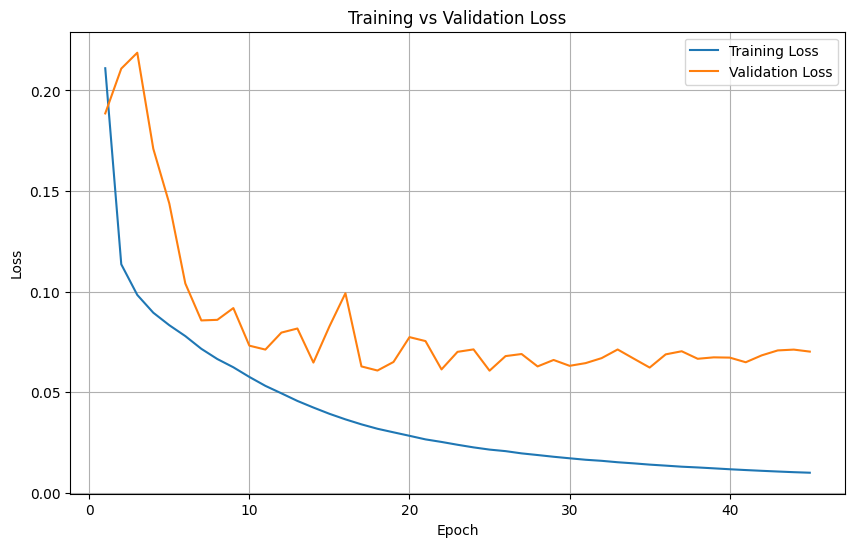

In [6]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import logging
import csv
import matplotlib.pyplot as plt

# Suppress TensorFlow CUDA warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Constants
SR = 16000
N_MELS = 229
HOP_LENGTH = 512
TARGET_FRAMES = 480
NOTES = 88
INPUT_DIR = "/kaggle/input"  # Base input directory
OUTPUT_DIR = os.path.join(INPUT_DIR, "preprocessed", "preprocessed")  # Point to the inner preprocessed directory
WORKING_DIR = "/kaggle/working"  # Where to save models
BATCH_SIZE = 8
ITERATIONS = 2400  # Adjusted to target ~50 epochs with 120 batches/epoch
CHECKPOINT_INTERVAL = 240  # Save checkpoint every 240 steps
CSV_FILE = os.path.join(WORKING_DIR, "training_metrics.csv")

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Verify directory structure
def verify_data_dirs():
    expected_dirs = [
        os.path.join(OUTPUT_DIR, 'train', 'mel'),
        os.path.join(OUTPUT_DIR, 'train', 'piano_roll'),
        os.path.join(OUTPUT_DIR, 'validation', 'mel'),
        os.path.join(OUTPUT_DIR, 'validation', 'piano_roll'),
        os.path.join(OUTPUT_DIR, 'test', 'mel'),
        os.path.join(OUTPUT_DIR, 'test', 'piano_roll')
    ]
    for dir_path in expected_dirs:
        if not os.path.exists(dir_path):
            logger.error(f"Directory {dir_path} not found.")
            logger.error(f"Contents of {os.path.dirname(dir_path)}: {os.listdir(os.path.dirname(dir_path))}")
            raise FileNotFoundError(f"Directory {dir_path} not found. Check dataset structure in {OUTPUT_DIR}.")
        if not os.listdir(dir_path):
            raise FileNotFoundError(f"Directory {dir_path} is empty. Check dataset contents.")

# Normalize adjacency matrix
def normalize_adj(A, symmetric=True):
    A = A + tf.eye(tf.shape(A)[0], dtype=tf.float32)
    d = tf.reduce_sum(A, axis=1)
    if symmetric:
        D_inv_sqrt = tf.linalg.diag(tf.pow(d, -0.5))
        return D_inv_sqrt @ A @ D_inv_sqrt
    else:
        D_inv = tf.linalg.diag(tf.pow(d, -1))
        return D_inv @ A

# Compute adjacency matrix
def compute_adjacency_matrix(train_roll_dir):
    train_rolls = []
    for f in os.listdir(train_roll_dir):
        if f.endswith('.npy'):
            roll = np.load(os.path.join(train_roll_dir, f))
            train_rolls.append(roll)
    
    all_frames = np.concatenate(train_rolls, axis=1)
    all_frames = (all_frames > 0).astype(np.float32)
    
    M = tf.matmul(all_frames, all_frames, transpose_b=True)
    M = M + tf.transpose(M)
    M_max = tf.reduce_max(M)
    P = M / M_max if M_max > 0 else M
    A = tf.cast(P >= 0.6, tf.float32)
    A = tf.cast((A + tf.transpose(A)) > 0, tf.float32)
    A = normalize_adj(A, symmetric=True)
    
    return A

# GCN Layer
class GCNSimple(tf.keras.layers.Layer):
    def __init__(self, dim_in, dim_out, **kwargs):
        super(GCNSimple, self).__init__(**kwargs)
        train_roll_dir = os.path.join(OUTPUT_DIR, 'train', 'piano_roll')
        self.A = tf.constant(compute_adjacency_matrix(train_roll_dir), dtype=tf.float32)
        self.fc1 = layers.Dense(dim_in, use_bias=False)
        self.fc2 = layers.Dense(dim_out // 2, use_bias=False)
        self.fc3 = layers.Dense(dim_out, use_bias=False)
    
    def call(self, inputs):
        X = tf.nn.relu(self.fc1(self.A))
        X = tf.nn.relu(self.fc2(tf.matmul(self.A, X)))
        X = self.fc3(tf.matmul(self.A, X))
        return tf.matmul(inputs, X)
    
    def get_config(self):
        config = super(GCNSimple, self).get_config()
        config.update({'dim_in': self.fc1.units, 'dim_out': self.fc3.units})
        return config

# ConvStack
def build_conv_stack(input_features, output_features):
    model = models.Sequential([
        layers.Input(shape=(None, input_features, 1)),
        layers.Conv2D(output_features // 16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(output_features // 16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((1, 2)),
        layers.Dropout(0.4),  # Increased to 0.4
        layers.Conv2D(output_features // 8, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((1, 2)),
        layers.Dropout(0.4),  # Increased to 0.4
        layers.Conv2D(output_features // 8, (3, 3), padding='same'),  # Extra layer
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Reshape((-1, (output_features // 8) * (input_features // 4))),
        layers.Dense(output_features, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dropout(0.4)
    ])
    return model

# OnsetsAndFrames model
class OnsetsAndFrames(Model):
    def __init__(self, input_features, output_features, model_complexity=96, **kwargs):  # Increased to 96
        super(OnsetsAndFrames, self).__init__(**kwargs)
        self.input_features = input_features
        self.output_features = output_features
        self.model_complexity = model_complexity
        model_size = model_complexity * 16
        
        self.onset_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True)),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.offset_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True)),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.frame_stack = models.Sequential([
            build_conv_stack(input_features, model_size),
            layers.Dense(output_features),
            layers.Activation('sigmoid')
        ])
        
        self.combined_stack = models.Sequential([
            layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True), 
                               input_shape=(None, output_features * 3)),
            layers.Dense(output_features),
            GCNSimple(output_features, output_features),
            layers.Activation('sigmoid')
        ])
    
    def call(self, mel, training=False):
        mel = tf.expand_dims(mel, -1)
        onset_pred = self.onset_stack(mel, training=training)
        offset_pred = self.offset_stack(mel, training=training)
        activation_pred = self.frame_stack(mel, training=training)
        combined_pred = tf.concat([onset_pred, offset_pred, activation_pred], axis=-1)
        frame_pred = self.combined_stack(combined_pred, training=training)
        return {'onset': onset_pred, 'offset': offset_pred, 'frame': frame_pred}
    
    def get_config(self):
        config = super(OnsetsAndFrames, self).get_config()
        config.update({
            'input_features': self.input_features,
            'output_features': self.output_features,
            'model_complexity': self.model_complexity
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        input_features = config.get('input_features', N_MELS)
        output_features = config.get('output_features', NOTES)
        model_complexity = config.get('model_complexity', 96)
        return cls(input_features=input_features, 
                   output_features=output_features, 
                   model_complexity=model_complexity)

# Data generator
class PianoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, split, batch_size=8, shuffle=False):
        self.split = split
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.audio_dir = os.path.join(OUTPUT_DIR, split, 'mel')
        self.roll_dir = os.path.join(OUTPUT_DIR, split, 'piano_roll')
        self.audio_files = [f for f in os.listdir(self.audio_dir) if f.endswith('.npy')]
        self.roll_files = [f for f in os.listdir(self.roll_dir) if f.endswith('.npy')]
        self.audio_files.sort()
        self.roll_files.sort()
        assert len(self.audio_files) == len(self.roll_files), f"Mismatch in {split}"
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.audio_files) // self.batch_size
    
    def __getitem__(self, idx):
        batch_audio_files = self.audio_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_roll_files = self.roll_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X = np.array([np.load(os.path.join(self.audio_dir, f)) for f in batch_audio_files])
        y = np.array([np.load(os.path.join(self.roll_dir, f)) for f in batch_roll_files])
        
        # Ensure 3D shape
        if X.ndim == 2:
            X = np.expand_dims(X, axis=0)
        if y.ndim == 2:
            y = np.expand_dims(y, axis=0)
        
        # Normalize X to [0, 1] and add light noise
        X = (X - np.min(X)) / (np.max(X) - np.min(X) + 1e-8)
        X = X + np.random.normal(0, 0.01, X.shape)  # Add small Gaussian noise
        
        # Transpose to (batch, frames, features)
        if X.shape[1] == N_MELS and X.shape[2] == TARGET_FRAMES:
            X = np.transpose(X, (0, 2, 1))
        elif X.shape[1] != TARGET_FRAMES or X.shape[2] != N_MELS:
            raise ValueError(f"Unexpected X shape: {X.shape}")
        
        if y.shape[1] == NOTES and y.shape[2] == TARGET_FRAMES:
            y = np.transpose(y, (0, 2, 1))
        elif y.shape[1] != TARGET_FRAMES or y.shape[2] != NOTES:
            raise ValueError(f"Unexpected y shape: {y.shape}")
        
        logger.info(f"X shape: {X.shape}, y shape: {y.shape}")
        return X, {'onset': y, 'offset': y, 'frame': y}
    
    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.audio_files))
            np.random.shuffle(indices)
            self.audio_files = [self.audio_files[i] for i in indices]
            self.roll_files = [self.roll_files[i] for i in indices]

# Custom training step with loss only
class CustomModel(Model):
    def __init__(self, onsets_and_frames_model):
        super(CustomModel, self).__init__()
        self.onsets_and_frames = onsets_and_frames_model
        self.clip_norm = 3.0
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.onset_loss_tracker = tf.keras.metrics.Mean(name="onset_loss")
        self.offset_loss_tracker = tf.keras.metrics.Mean(name="offset_loss")
        self.frame_loss_tracker = tf.keras.metrics.Mean(name="frame_loss")
        self.val_loss_tracker = tf.keras.metrics.Mean(name="val_loss")
        self.val_onset_loss_tracker = tf.keras.metrics.Mean(name="val_onset_loss")
        self.val_offset_loss_tracker = tf.keras.metrics.Mean(name="val_offset_loss")
        self.val_frame_loss_tracker = tf.keras.metrics.Mean(name="val_frame_loss")
    
    def call(self, inputs, training=False):
        return self.onsets_and_frames(inputs, training=training)
    
    def compute_loss(self, x, y, y_pred, sample_weight=None, training=True):
        losses = {}
        for key in ['onset', 'offset', 'frame']:
            losses[key] = tf.keras.losses.binary_crossentropy(y[key], y_pred[key])
        total_loss = sum(losses.values()) / len(losses)
        return total_loss, losses['onset'], losses['offset'], losses['frame']
    
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            total_loss, onset_loss, offset_loss, frame_loss = self.compute_loss(x, y, y_pred)
        
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        gradients = [tf.clip_by_norm(g, self.clip_norm) if g is not None else g for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        self.loss_tracker.update_state(total_loss)
        self.onset_loss_tracker.update_state(onset_loss)
        self.offset_loss_tracker.update_state(offset_loss)
        self.frame_loss_tracker.update_state(frame_loss)
        
        return {
            "loss": self.loss_tracker.result(),
            "onset_loss": self.onset_loss_tracker.result(),
            "offset_loss": self.offset_loss_tracker.result(),
            "frame_loss": self.frame_loss_tracker.result()
        }
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        total_loss, onset_loss, offset_loss, frame_loss = self.compute_loss(x, y, y_pred)
        
        self.val_loss_tracker.update_state(total_loss)
        self.val_onset_loss_tracker.update_state(onset_loss)
        self.val_offset_loss_tracker.update_state(offset_loss)
        self.val_frame_loss_tracker.update_state(frame_loss)
        
        return {
            "loss": self.val_loss_tracker.result(),
            "onset_loss": self.val_onset_loss_tracker.result(),
            "offset_loss": self.val_offset_loss_tracker.result(),
            "frame_loss": self.val_frame_loss_tracker.result()
        }
    
    @property
    def metrics(self):
        return [
            self.loss_tracker, self.onset_loss_tracker, self.offset_loss_tracker, self.frame_loss_tracker,
            self.val_loss_tracker, self.val_onset_loss_tracker, self.val_offset_loss_tracker, self.val_frame_loss_tracker
        ]

# Training function
def train_model():
    train_gen = PianoDataGenerator('train', batch_size=BATCH_SIZE)
    val_gen = PianoDataGenerator('validation', batch_size=BATCH_SIZE)
    
    batches_per_epoch = len(train_gen)
    total_epochs = 100
    logger.info(f"Training for {total_epochs} epochs with {batches_per_epoch} batches/epoch")
    
    onsets_and_frames = OnsetsAndFrames(input_features=N_MELS, output_features=NOTES)
    model = CustomModel(onsets_and_frames)
    
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=0.0001,
        decay_steps=total_epochs * batches_per_epoch
    )
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=None,
        metrics=None
    )
    
    checkpoint = ModelCheckpoint(
        os.path.join(WORKING_DIR, "best_model.keras"),
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=20,  # Increased to 20
        restore_best_weights=True,
        verbose=1
    )
    
    class CSVMetricsCallback(tf.keras.callbacks.Callback):
        def __init__(self, csv_file):
            super().__init__()
            self.csv_file = csv_file
            self.metrics = []
            if os.path.exists(csv_file):
                os.remove(csv_file)
            with open(csv_file, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(["epoch", "loss", "onset_loss", "offset_loss", "frame_loss", 
                               "val_loss", "val_onset_loss", "val_offset_loss", "val_frame_loss"])
        
        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            row = [
                epoch + 1,
                logs.get('loss', 0),
                logs.get('onset_loss', 0),
                logs.get('offset_loss', 0),
                logs.get('frame_loss', 0),
                logs.get('val_loss', logs.get('val_val_loss', 0)),
                logs.get('val_onset_loss', logs.get('val_val_onset_loss', 0)),
                logs.get('val_offset_loss', logs.get('val_val_offset_loss', 0)),
                logs.get('val_frame_loss', logs.get('val_val_frame_loss', 0))
            ]
            self.metrics.append(row)
            with open(self.csv_file, 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(row)
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=total_epochs,
        callbacks=[checkpoint, early_stopping, CSVMetricsCallback(CSV_FILE)],
        verbose=1
    )
    
    return model, history

# Evaluation function
def evaluate_model(model, test_gen):
    max_samples = min(10, len(test_gen))
    Y_true_all, Y_pred_all = [], []
    
    for i in range(max_samples):
        try:
            batch_x, batch_y = test_gen[i]
            batch_y = batch_y['frame']
        except ValueError as e:
            print(f"⏭️ Skipping batch {i}: {e}")
            continue
        
        preds = model.predict(batch_x, verbose=0)
        pred_frame = preds['frame']
        pred_frame = np.where(pred_frame > 0.3, 1, 0)  # Adjusted threshold to 0.3 for recall
        
        Y_pred_all.append(pred_frame[0] if BATCH_SIZE == 1 else pred_frame)
        Y_true_all.append(batch_y[0] if BATCH_SIZE == 1 else batch_y)
    
    Y_true_flat = np.concatenate(Y_true_all).reshape(-1)
    Y_pred_flat = np.concatenate(Y_pred_all).reshape(-1)
    
    frame_precision = precision_score(Y_true_flat, Y_pred_flat, zero_division=0)
    frame_recall = recall_score(Y_true_flat, Y_pred_flat, zero_division=0)
    frame_f1 = f1_score(Y_true_flat, Y_pred_flat, zero_division=0)
    
    print("\n🎯 Frame-level Metrics:")
    print(f"Precision: {frame_precision:.4f}")
    print(f"Recall: {frame_recall:.4f}")
    print(f"F1-score: {frame_f1:.4f}")
    
    if frame_f1 >= 0.9277:
        print("\nFrame F1 Score exceeds CR-GCN's 92.77% - Excellent!")
    else:
        print(f"\nFrame F1 Score is {frame_f1:.4f}, below CR-GCN's 92.77%. Consider further optimization.")
    
    return frame_f1

# Plot training vs validation loss
def plot_training_validation_curve(csv_file):
    if not os.path.exists(csv_file):
        print(f"Error: {csv_file} not found. Ensure training completed.")
        return
    
    df = pd.read_csv(csv_file)
    plt.figure(figsize=(10, 6))
    plt.plot(df['epoch'], df['loss'], label='Training Loss')
    plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(WORKING_DIR, 'training_validation_loss.png'))
    plt.show()

if __name__ == '__main__':
    verify_data_dirs()
    model, history = train_model()
    test_gen = PianoDataGenerator('validation', batch_size=BATCH_SIZE, shuffle=False)
    evaluate_model(model, test_gen)
    model.save(os.path.join(WORKING_DIR, "final_model.keras"))
    logger.info(f"Saved final model to {os.path.join(WORKING_DIR, 'final_model.keras')}")
    plot_training_validation_curve(CSV_FILE)

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import logging
import csv
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
import pandas as pd

# Suppress TensorFlow CUDA warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Constants
SR = 16000
N_MELS = 229
HOP_LENGTH = 512
TARGET_FRAMES = 480  # Consider reducing if memory issues persist
NOTES = 88
INPUT_DIR = "/kaggle/input"
OUTPUT_DIR = os.path.join(INPUT_DIR, "preprocessed", "preprocessed")
WORKING_DIR = "/kaggle/working"
BATCH_SIZE = 2  # Reduced from 8 to lower memory usage
ITERATIONS = 2400
CHECKPOINT_INTERVAL = 240
CSV_FILE = os.path.join(WORKING_DIR, "training_metrics.csv")

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Verify directory structure
def verify_data_dirs():
    expected_dirs = [
        os.path.join(OUTPUT_DIR, 'train', 'mel'),
        os.path.join(OUTPUT_DIR, 'train', 'piano_roll'),
        os.path.join(OUTPUT_DIR, 'validation', 'mel'),
        os.path.join(OUTPUT_DIR, 'validation', 'piano_roll'),
        os.path.join(OUTPUT_DIR, 'test', 'mel'),
        os.path.join(OUTPUT_DIR, 'test', 'piano_roll')
    ]
    for dir_path in expected_dirs:
        if not os.path.exists(dir_path):
            logger.error(f"Directory {dir_path} not found.")
            raise FileNotFoundError(f"Directory {dir_path} not found.")

# Normalize adjacency matrix
def normalize_adj(A, symmetric=True):
    A = A + tf.eye(tf.shape(A)[0], dtype=tf.float32)
    d = tf.reduce_sum(A, axis=1)
    if symmetric:
        D_inv_sqrt = tf.linalg.diag(tf.pow(d, -0.5))
        return D_inv_sqrt @ A @ D_inv_sqrt
    else:
        D_inv = tf.linalg.diag(tf.pow(d, -1))
        return D_inv @ A

# Compute adjacency matrix
def compute_adjacency_matrix(train_roll_dir):
    train_rolls = []
    for f in os.listdir(train_roll_dir):
        if f.endswith('.npy'):
            roll = np.load(os.path.join(train_roll_dir, f))
            train_rolls.append(roll)
    all_frames = np.concatenate(train_rolls, axis=1)
    all_frames = (all_frames > 0).astype(np.float32)
    M = tf.matmul(all_frames, all_frames, transpose_b=True)
    M = M + tf.transpose(M)
    M_max = tf.reduce_max(M)
    P = M / M_max if M_max > 0 else M
    A = tf.cast(P >= 0.6, tf.float32)
    A = tf.cast((A + tf.transpose(A)) > 0, tf.float32)
    A = normalize_adj(A, symmetric=True)
    return A

# GCN Layer
class GCNSimple(tf.keras.layers.Layer):
    def __init__(self, dim_in, dim_out, **kwargs):
        super(GCNSimple, self).__init__(**kwargs)
        train_roll_dir = os.path.join(OUTPUT_DIR, 'train', 'piano_roll')
        self.A = tf.constant(compute_adjacency_matrix(train_roll_dir), dtype=tf.float32)
        self.fc1 = layers.Dense(dim_in, use_bias=False)
        self.fc2 = layers.Dense(dim_out // 2, use_bias=False)
        self.fc3 = layers.Dense(dim_out, use_bias=False)
    
    def call(self, inputs):
        X = tf.nn.relu(self.fc1(self.A))
        X = tf.nn.relu(self.fc2(tf.matmul(self.A, X)))
        X = self.fc3(tf.matmul(self.A, X))
        return tf.matmul(inputs, X)
    
    def get_config(self):
        config = super(GCNSimple, self).get_config()
        config.update({'dim_in': self.fc1.units, 'dim_out': self.fc3.units})
        return config

# ConvStack
def build_conv_stack(input_features, output_features):
    model = models.Sequential([
        layers.Input(shape=(None, input_features, 1)),
        layers.Conv2D(output_features // 16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(output_features // 16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((1, 2)),
        layers.Dropout(0.4),
        layers.Conv2D(output_features // 8, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((1, 2)),
        layers.Conv2D(output_features // 8, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Reshape((-1, (output_features // 8) * (input_features // 4))),
        layers.Dense(output_features, kernel_regularizer=tf.keras.regularizers.l2(0.02)),
        layers.Dropout(0.4)
    ])
    return model

# OnsetsAndFrames model with Input layer
class OnsetsAndFrames(Model):
    def __init__(self, input_features, output_features, model_complexity=48, **kwargs):  # Reduced from 96 to 48
        super(OnsetsAndFrames, self).__init__(**kwargs)
        self.input_features = input_features
        self.output_features = output_features
        self.model_complexity = model_complexity
        model_size = model_complexity * 16
        
        # Onset stack
        onset_input = layers.Input(shape=(None, input_features, 1))
        x = build_conv_stack(input_features, model_size)(onset_input)
        x = layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True))(x)
        x = layers.Dropout(0.3)(x)
        onset_output = layers.Dense(output_features, activation='sigmoid')(x)
        self.onset_stack = models.Model(onset_input, onset_output)
        
        # Offset stack
        offset_input = layers.Input(shape=(None, input_features, 1))
        x = build_conv_stack(input_features, model_size)(offset_input)
        x = layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True))(x)
        x = layers.Dropout(0.3)(x)
        offset_output = layers.Dense(output_features, activation='sigmoid')(x)
        self.offset_stack = models.Model(offset_input, offset_output)
        
        # Frame stack
        frame_input = layers.Input(shape=(None, input_features, 1))
        x = build_conv_stack(input_features, model_size)(frame_input)
        frame_output = layers.Dense(output_features, activation='sigmoid')(x)
        self.frame_stack = models.Model(frame_input, frame_output)
        
        # Combined stack
        combined_input = layers.Input(shape=(None, output_features * 3))
        x = layers.Bidirectional(layers.LSTM(model_size // 2, return_sequences=True))(combined_input)
        x = layers.Dense(output_features)(x)
        x = GCNSimple(output_features, output_features)(x)
        combined_output = layers.Activation('sigmoid')(x)
        self.combined_stack = models.Model(combined_input, combined_output)
    
    def call(self, mel, training=False):
        mel = tf.expand_dims(mel, -1)
        onset_pred = self.onset_stack(mel, training=training)
        offset_pred = self.offset_stack(mel, training=training)
        activation_pred = self.frame_stack(mel, training=training)
        combined_pred = tf.concat([onset_pred, offset_pred, activation_pred], axis=-1)
        frame_pred = self.combined_stack(combined_pred, training=training)
        return {'onset': onset_pred, 'offset': offset_pred, 'frame': frame_pred}
    
    def get_config(self):
        config = super(OnsetsAndFrames, self).get_config()
        config.update({'input_features': self.input_features, 'output_features': self.output_features, 'model_complexity': self.model_complexity})
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Data generator
class PianoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, split, batch_size=2, shuffle=False):  # Reduced batch size
        self.split = split
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.audio_dir = os.path.join(OUTPUT_DIR, split, 'mel')
        self.roll_dir = os.path.join(OUTPUT_DIR, split, 'piano_roll')
        self.audio_files = [f for f in os.listdir(self.audio_dir) if f.endswith('.npy')]
        self.roll_files = [f for f in os.listdir(self.roll_dir) if f.endswith('.npy')]
        self.audio_files.sort()
        self.roll_files.sort()
        assert len(self.audio_files) == len(self.roll_files), f"Mismatch in {split}"
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.audio_files) // self.batch_size
    
    def __getitem__(self, idx):
        batch_audio_files = self.audio_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_roll_files = self.roll_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X = np.array([np.load(os.path.join(self.audio_dir, f)) for f in batch_audio_files])
        y = np.array([np.load(os.path.join(self.roll_dir, f)) for f in batch_roll_files])
        
        if X.ndim == 2:
            X = np.expand_dims(X, axis=0)
        if y.ndim == 2:
            y = np.expand_dims(y, axis=0)
        
        # Normalize and augment
        X = (X - np.min(X)) / (np.max(X) - np.min(X) + 1e-8)
        X = X + np.random.normal(0, 0.01, X.shape)  # Noise
        X = np.clip(X * np.random.uniform(0.9, 1.1, X.shape), 0, 1)  # Time stretching effect
        
        if X.shape[1] == N_MELS and X.shape[2] == TARGET_FRAMES:
            X = np.transpose(X, (0, 2, 1))
        if y.shape[1] == NOTES and y.shape[2] == TARGET_FRAMES:
            y = np.transpose(y, (0, 2, 1))
        
        logger.info(f"X shape: {X.shape}, y shape: {y.shape}")
        
        return X, {'onset': y, 'offset': y, 'frame': y}
    
    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.audio_files))
            np.random.shuffle(indices)
            self.audio_files = [self.audio_files[i] for i in indices]
            self.roll_files = [self.roll_files[i] for i in indices]

# Custom training step with manual binary cross-entropy
class CustomModel(Model):
    def __init__(self, onsets_and_frames_model):
        super(CustomModel, self).__init__()
        self.onsets_and_frames = onsets_and_frames_model
        self.clip_norm = 1.0
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.onset_loss_tracker = tf.keras.metrics.Mean(name="onset_loss")
        self.offset_loss_tracker = tf.keras.metrics.Mean(name="offset_loss")
        self.frame_loss_tracker = tf.keras.metrics.Mean(name="frame_loss")
        self.val_loss_tracker = tf.keras.metrics.Mean(name="val_loss")
        self.val_onset_loss_tracker = tf.keras.metrics.Mean(name="val_onset_loss")
        self.val_offset_loss_tracker = tf.keras.metrics.Mean(name="val_offset_loss")
        self.val_frame_loss_tracker = tf.keras.metrics.Mean(name="val_frame_loss")
    
    def call(self, inputs, training=False):
        return self.onsets_and_frames(inputs, training=training)
    
    def compute_loss(self, x, y, y_pred, training=True):
        losses = {}
        for key in ['onset', 'offset', 'frame']:
            y_true = tf.cast(y[key], tf.float32)
            y_pred_key = y_pred[key]
            # Compute class weights dynamically
            pos_weight = tf.reduce_mean(y_true)  # Mean of positive class across all dimensions
            neg_weight = 1 - pos_weight
            # Create weight tensor with the same shape as y_true
            weights = tf.where(y_true > 0, pos_weight / (pos_weight + 1e-8), neg_weight / (neg_weight + 1e-8))
            # Manual binary cross-entropy
            epsilon = 1e-7
            y_pred_key = tf.clip_by_value(y_pred_key, epsilon, 1 - epsilon)
            bce = - (y_true * tf.math.log(y_pred_key) + (1 - y_true) * tf.math.log(1 - y_pred_key))
            # Apply weights element-wise
            weighted_loss = bce * tf.cast(weights, tf.float32)
            losses[key] = tf.reduce_mean(weighted_loss)
            logger.info(f"Shapes - y_true: {y_true.shape}, y_pred_key: {y_pred_key.shape}, weights: {weights.shape}, bce: {bce.shape}, weighted_loss: {weighted_loss.shape}")
        total_loss = sum(losses.values()) / len(losses)
        return total_loss, losses['onset'], losses['offset'], losses['frame']
    
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            total_loss, onset_loss, offset_loss, frame_loss = self.compute_loss(x, y, y_pred, training=True)
        
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        gradients = [tf.clip_by_norm(g, self.clip_norm) if g is not None else g for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        self.loss_tracker.update_state(total_loss)
        self.onset_loss_tracker.update_state(onset_loss)
        self.offset_loss_tracker.update_state(offset_loss)
        self.frame_loss_tracker.update_state(frame_loss)
        
        return {
            "loss": self.loss_tracker.result(),
            "onset_loss": self.onset_loss_tracker.result(),
            "offset_loss": self.offset_loss_tracker.result(),
            "frame_loss": self.frame_loss_tracker.result()
        }
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        total_loss, onset_loss, offset_loss, frame_loss = self.compute_loss(x, y, y_pred, training=False)
        
        self.val_loss_tracker.update_state(total_loss)
        self.val_onset_loss_tracker.update_state(onset_loss)
        self.val_offset_loss_tracker.update_state(offset_loss)
        self.val_frame_loss_tracker.update_state(frame_loss)
        
        return {
            "loss": self.val_loss_tracker.result(),
            "onset_loss": self.val_onset_loss_tracker.result(),
            "offset_loss": self.val_offset_loss_tracker.result(),
            "frame_loss": self.val_frame_loss_tracker.result()
        }
    
    @property
    def metrics(self):
        return [
            self.loss_tracker, self.onset_loss_tracker, self.offset_loss_tracker, self.frame_loss_tracker,
            self.val_loss_tracker, self.val_onset_loss_tracker, self.val_offset_loss_tracker, self.val_frame_loss_tracker
        ]

# Training function
def train_model():
    train_gen = PianoDataGenerator('train', batch_size=BATCH_SIZE)
    val_gen = PianoDataGenerator('validation', batch_size=BATCH_SIZE)
    
    batches_per_epoch = len(train_gen)
    total_epochs = 100
    logger.info(f"Training for {total_epochs} epochs with {batches_per_epoch} batches/epoch")
    
    onsets_and_frames = OnsetsAndFrames(input_features=N_MELS, output_features=NOTES)
    model = CustomModel(onsets_and_frames)
    
    lr_schedule = CosineDecay(
        initial_learning_rate=0.0001,
        decay_steps=total_epochs * batches_per_epoch
    )
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=None,
        metrics=None
    )
    
    checkpoint = ModelCheckpoint(
        os.path.join(WORKING_DIR, "best_model.keras"),
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=30,
        restore_best_weights=True,
        verbose=1
    )
    
    class CSVMetricsCallback(tf.keras.callbacks.Callback):
        def __init__(self, csv_file):
            super().__init__()
            self.csv_file = csv_file
            if os.path.exists(csv_file):
                os.remove(csv_file)
            with open(csv_file, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(["epoch", "loss", "onset_loss", "offset_loss", "frame_loss", 
                               "val_loss", "val_onset_loss", "val_offset_loss", "val_frame_loss"])
        
        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            row = [epoch + 1, logs.get('loss', 0), logs.get('onset_loss', 0), logs.get('offset_loss', 0), 
                   logs.get('frame_loss', 0), logs.get('val_loss', 0), logs.get('val_onset_loss', 0), 
                   logs.get('val_offset_loss', 0), logs.get('val_frame_loss', 0)]
            with open(self.csv_file, 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(row)
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=total_epochs,
        callbacks=[checkpoint, early_stopping, CSVMetricsCallback(CSV_FILE)],
        verbose=1
    )
    
    return model, history

# Evaluation function with threshold tuning
def evaluate_model(model, test_gen):
    max_samples = min(10, len(test_gen))
    Y_true_all, Y_pred_all = [], []
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in [0.2, 0.3, 0.4, 0.5]:
        Y_true_all, Y_pred_all = [], []
        for i in range(max_samples):
            try:
                batch_x, batch_y = test_gen[i]
                batch_y = batch_y['frame']
            except ValueError as e:
                print(f"⏭️ Skipping batch {i}: {e}")
                continue
            
            preds = model.predict(batch_x, verbose=0)
            pred_frame = preds['frame']
            pred_frame = np.where(pred_frame > threshold, 1, 0)
            pred_frame = median_filter(pred_frame, size=(1, 3))  # Post-processing
            
            Y_pred_all.append(pred_frame[0] if BATCH_SIZE == 1 else pred_frame)
            Y_true_all.append(batch_y[0] if BATCH_SIZE == 1 else batch_y)
        
        Y_true_flat = np.concatenate(Y_true_all).reshape(-1)
        Y_pred_flat = np.concatenate(Y_pred_all).reshape(-1)
        
        frame_precision = precision_score(Y_true_flat, Y_pred_flat, zero_division=0)
        frame_recall = recall_score(Y_true_flat, Y_pred_flat, zero_division=0)
        frame_f1 = f1_score(Y_true_flat, Y_pred_flat, zero_division=0)
        
        print(f"\n🎯 Frame-level Metrics (Threshold {threshold}):")
        print(f"Precision: {frame_precision:.4f}")
        print(f"Recall: {frame_recall:.4f}")
        print(f"F1-score: {frame_f1:.4f}")
        
        if frame_f1 > best_f1:
            best_f1 = frame_f1
            best_threshold = threshold
    
    print(f"\nBest F1-score: {best_f1:.4f} at threshold {best_threshold}")
    if best_f1 >= 0.9277:
        print("\nFrame F1 Score exceeds CR-GCN's 92.77% - Excellent!")
    else:
        print(f"\nFrame F1 Score is {best_f1:.4f}, below CR-GCN's 92.77%. Consider further optimization.")
    
    return best_f1

# Plot training vs validation loss
def plot_training_validation_curve(csv_file):
    if not os.path.exists(csv_file):
        print(f"Error: {csv_file} not found.")
        return
    df = pd.read_csv(csv_file)
    plt.figure(figsize=(10, 6))
    plt.plot(df['epoch'], df['loss'], label='Training Loss')
    plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(WORKING_DIR, 'training_validation_loss.png'))
    plt.show()

if __name__ == '__main__':
    verify_data_dirs()
    model, history = train_model()
    test_gen = PianoDataGenerator('validation', batch_size=BATCH_SIZE, shuffle=False)
    evaluate_model(model, test_gen)
    model.save(os.path.join(WORKING_DIR, "final_model.keras"))
    logger.info(f"Saved final model to {os.path.join(WORKING_DIR, 'final_model.keras')}")
    plot_training_validation_curve(CSV_FILE)

2025-04-20 21:43:06.007833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745185386.422528      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745185386.546205      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1745185405.625015      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745185405.625741      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Epoch 1/100


E0000 00:00:1745185441.022415      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/custom_model_1/onsets_and_frames_1/functional_1_1/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745185442.853952      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - frame_loss: 0.3399 - loss: 0.2425 - offset_loss: 0.1924 - onset_loss: 0.1951
Epoch 1: val_loss improved from inf to 0.15723, saving model to /kaggle/working/best_model.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 236s 431ms/step - frame_loss: 0.3397 - loss: 0.2423 - offset_loss: 0.1923 - onset_loss: 0.1950 - val_frame_loss: 0.1483 - val_loss: 0.1572 - val_offset_loss: 0.1605 - val_onset_loss: 0.1629
Epoch 2/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - frame_loss: 0.1560 - loss: 0.1166 - offset_loss: 0.0967 - onset_loss: 0.0970
Epoch 2: val_loss improved from 0.15723 to 0.09940, saving model to /kaggle/working/best_model.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 209s 433ms/step - frame_loss: 0.1560 - loss: 0.1166 - offset_loss: 0.0967 - onset_loss: 0.0970 - val_frame_loss: 0.1411 - val_loss: 0.0994 - val_offset_loss: 0.0796 - val_onset_loss: 0.0775
Epoch 3/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - frame_loss: 0.1442 - loss: 0.0999 - offset_loss: 0.

RuntimeError: sequence argument must have length equal to input rank

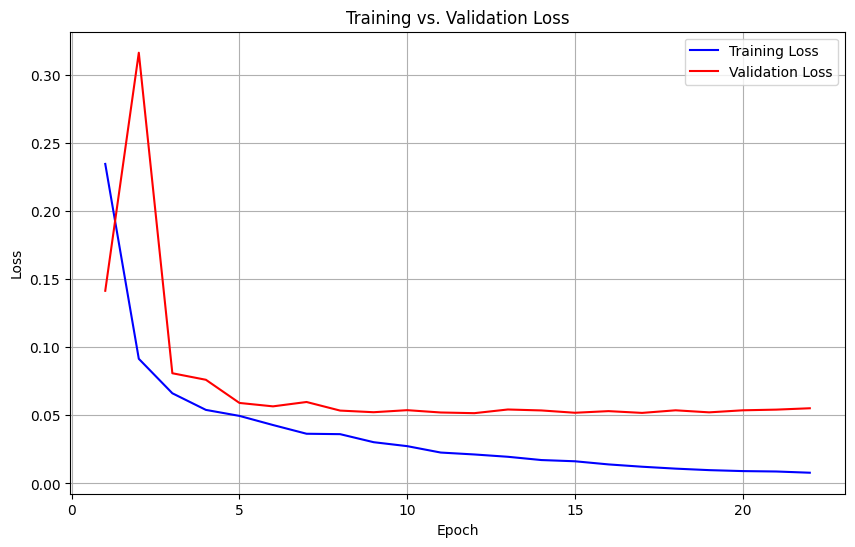

In [8]:
import matplotlib.pyplot as plt

# Loss values extracted from training log
train_loss = [
    0.2345, 0.0915, 0.0662, 0.0540, 0.0496, 0.0429, 0.0365, 0.0362, 
    0.0303, 0.0274, 0.0227, 0.0213, 0.0196, 0.0172, 0.0163, 0.0140, 
    0.0123, 0.0109, 0.0098, 0.0091, 0.0088, 0.0079
]
val_loss = [
    0.1414, 0.3161, 0.0809, 0.0761, 0.0591, 0.0566, 0.0598, 0.0535, 
    0.0523, 0.0538, 0.0521, 0.0516, 0.0543, 0.0536, 0.0519, 0.0531, 
    0.0518, 0.0537, 0.0522, 0.0537, 0.0542, 0.0552
]
epochs = list(range(1, 23))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Save the plot
plt.savefig('loss_curve.png')